## FIW Databas Overview

- Families In the Wild (FIW) is the largest and most comprehensive image database for automatic kinship recognition. It is made-up of 11,932 family photos that span 1,000 different families, with the data distributed fairly with average of about 12 images per family, each with at least 3 and as many as 38 members. This data supports all prior pair-wise types and also introduces grandparent-grandchild pairs (GF-GD, GF-GS, GM-GD, GM-GS). In addition of it is a public and noncommercial database.


- Int this part of the project the kaggle version of the database will be used to solve the kinship verification task.

In [1]:
import os
import glob
import base64
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from IPython.display import HTML
from collections import defaultdict

## Data Cleansing & Exploration

__1)__  Defining some useful functions for data preprocessing and visualizations.

In [2]:
pd.set_option('display.max_colwidth', -1)
######################################################################
###### Function that returns the thumbnail version of an image  ######
######################################################################
def get_thumbnail(path):
    if path and os.path.exists(path):
        i = Image.open(path)
        i.thumbnail((150, 150), Image.LANCZOS)
        return i
######################################################################
####### Function that returns the base64 format from an image  #######
######################################################################
def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
######################################################################
############## Function that returns the image format  ###############
######################################################################
def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'
######################################################################
######## Function that returns the image path from it's code  ########
######################################################################
def add_image_path(x,path):
    image_path = path + x
    if os.path.exists(image_path):
        path = os.path.join(image_path, os.listdir(image_path)[0])
        return path

__2)__  Loading the train_relationships file as a dataframe in the kin_data variable and exploring it's content to find out that it consists of 3598 records each record is a family and member codes for the pair of images.

In [3]:
kin_data = pd.read_csv('kaggle/train_relationships.csv')
print(kin_data.shape)
kin_data.head()

(3598, 2)


,p1,p2
0,F0002/MID1,F0002/MID3
1,F0002/MID2,F0002/MID3
2,F0005/MID1,F0005/MID2
3,F0005/MID3,F0005/MID2
4,F0009/MID1,F0009/MID4


__3)__ Looping in the directory that contains the training data and:

    - Keep the tag (family code/member code) of all existing photos of members in the database.
    - Keep the path (family code/member code/image code) of all of the existing photos at the database in the allphotos dictionary.
    
    
- Because of we using the kaggle version of the data there may be some recods that refer to unexisting members so this step will helping to make sure that this will never happen.

In [4]:
#keeps all photos path in a dictionary
allPhotos = defaultdict(list)
for family in glob.glob("kaggle/train/*"):
    for mem in glob.glob(family + '/*'):
        for photo in glob.glob(mem + '/*'):
            allPhotos[mem].append(photo)

#list of all members with valid photo
ppl = list(allPhotos.keys())
print("number of the members with valid photo",len(ppl))
print("sample of the ppl content: ", ppl[:3])

number of the members with valid photo 2316
sample of the ppl content:  ['kaggle/train/F0390/MID11', 'kaggle/train/F0390/MID5', 'kaggle/train/F0390/MID9']


__4)__ Add 2 columns __p1_path & p2_path__ in the dataframe that represents the path of the member folder that contains all of his/her photos.

In [5]:
kin_data['p1_path'] = kin_data.p1.apply(lambda x: 'kaggle/train/' + x)
kin_data['p2_path'] = kin_data.p2.apply(lambda x: 'kaggle/train/' + x)
print(kin_data.shape)
kin_data.head()

(3598, 4)


,p1,p2,p1_path,p2_path
0,F0002/MID1,F0002/MID3,kaggle/train/F0002/MID1,kaggle/train/F0002/MID3
1,F0002/MID2,F0002/MID3,kaggle/train/F0002/MID2,kaggle/train/F0002/MID3
2,F0005/MID1,F0005/MID2,kaggle/train/F0005/MID1,kaggle/train/F0005/MID2
3,F0005/MID3,F0005/MID2,kaggle/train/F0005/MID3,kaggle/train/F0005/MID2
4,F0009/MID1,F0009/MID4,kaggle/train/F0009/MID1,kaggle/train/F0009/MID4


__5)__ Loopingon all the records and find if it's path existing in the ppl that contains all members paths or not, if not the record will be excluded.

- Number of records after data cleansing is 3362 instead of 3598 records.

In [6]:
kin_data = kin_data[((kin_data.p1_path.isin(ppl)) & (kin_data.p2_path.isin(ppl)))]
print(len(kin_data))

3362


__6)__

In [7]:
sample_data = kin_data.sample(50)
sample_data['p1_path'] = sample_data.p1.apply(lambda f: add_image_path(f, 'kaggle/train/'))
sample_data['p2_path'] = sample_data.p2.apply(lambda f: add_image_path(f, 'kaggle/train/'))
sample_data['p1_thumb'] = sample_data.p1_path.map(lambda f: get_thumbnail(f))
sample_data['p2_thumb'] = sample_data.p2_path.map(lambda f: get_thumbnail(f))
print(sample_data.shape)
sample_data.head()

(50, 6)


,p1,p2,p1_path,p2_path,p1_thumb,p2_thumb
873,F0237/MID4,F0237/MID2,kaggle/train/F0237/MID4/P02511_face2.jpg,kaggle/train/F0237/MID2/P02509_face1.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7FD7C0F20EF0>,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7FD7C0E595C0>
2641,F0752/MID1,F0752/MID7,kaggle/train/F0752/MID1/P07891_face4.jpg,kaggle/train/F0752/MID7/P07904_face4.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7FD7C0EAA390>,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7FD7C0E59668>
3174,F0868/MID1,F0868/MID2,kaggle/train/F0868/MID1/P09167_face1.jpg,kaggle/train/F0868/MID2/P09174_face2.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7FD7C0EB4470>,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7FD7C0E59710>
1407,F0402/MID2,F0402/MID4,kaggle/train/F0402/MID2/P04238_face1.jpg,kaggle/train/F0402/MID4/P04236_face3.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7FD7C0EB4518>,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7FD7C0E597B8>
1388,F0393/MID2,F0393/MID5,kaggle/train/F0393/MID2/P04157_face1.jpg,kaggle/train/F0393/MID5/P04154_face1.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7FD7C0EB45C0>,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7FD7C0E59860>


,p1,p2,p1_thumb,p2_thumb
873,F0237/MID4,F0237/MID2,,
2641,F0752/MID1,F0752/MID7,,
3174,F0868/MID1,F0868/MID2,,
1407,F0402/MID2,F0402/MID4,,
1388,F0393/MID2,F0393/MID5,,

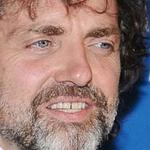
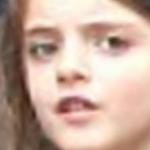
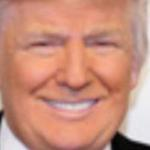
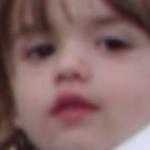
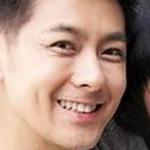
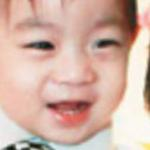
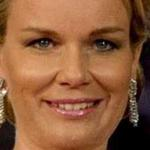
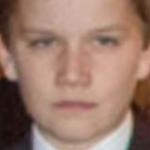
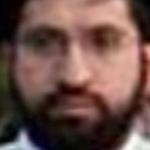
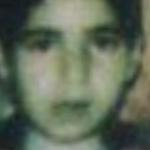

In [8]:
HTML(sample_data.head()[['p1', 'p2', 'p1_thumb', 'p2_thumb']].to_html(formatters={'p1_thumb': image_formatter, 'p2_thumb': image_formatter}, escape=False))

## Data Analysis

__1)__ To make a more understandable analysis the 1000 family will be divided into 10 groups each have a 100 possible family on it. 

__2)__ Counting the number of occurence of each group in the dataframe that will be used for training our model.

In [9]:
# from the training pairs how many pairs come from a range of 100 of family codes
fam = ['F00', 'F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10']
f = {}
for family in fam:
    f[family] = kin_data.p1.str.count(family).sum() + kin_data.p2.str.count(family).sum()
    
print(f)

{'F00': 520, 'F01': 782, 'F02': 662, 'F03': 604, 'F04': 590, 'F05': 602, 'F06': 786, 'F07': 794, 'F08': 748, 'F09': 592, 'F10': 44}


__3)__ Counting the number of members in each group.

__4)__ Counting the actual number of family codes in each group.

In [10]:
# count the number of members in the dataset per a subset of 100 of family codes
counter = {}
count = 0

for family in glob.glob("kaggle/train/*"):
    count = 0
    for mem in glob.glob(family + '/*'):
        count += 1
        counter[family] = count
    
c = pd.DataFrame.from_dict(counter, orient = 'index').reset_index().rename(columns = {'index':'family', 0:'count'})

z = {}
for famil in fam:
    z[famil] = c.family.str.count(famil).sum()

In [11]:
# count the number of exists families of each subset of 100 family codes
n_families = {}

for x in fam:
    count = 0
    for family in glob.glob("kaggle/train/*"):
        count += (x in family)
        n_families[x] = count


__3)__ Visualize all of the above analysis.

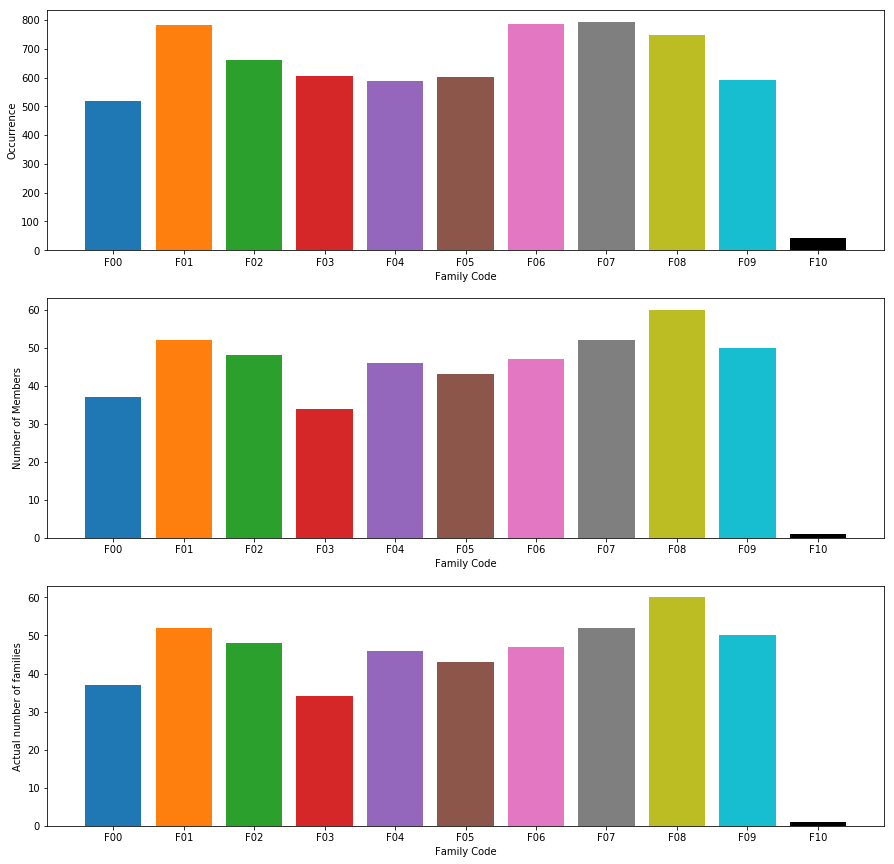

In [12]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'black']

x1 = f.keys()
x2 = z.keys()
x3 = n_families.keys()

y1 = f.values()
y2 = z.values()
y3 = n_families.values()

fig, ax = plt.subplots(3)

ax[0].bar(x1, y1, color = colors)
ax[0].set(xlabel = 'Family Code', ylabel = 'Occurrence')

ax[1].bar(x2, y2, color = colors)
ax[1].set(xlabel = 'Family Code', ylabel = 'Number of Members')

ax[2].bar(x3, y3, color = colors)
ax[2].set(xlabel = 'Family Code', ylabel = 'Actual number of families')

fig.set_figheight(15)
fig.set_figwidth(15)
plt.show()